In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt
import optuna
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

2024-10-13 09:59:28.972534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 09:59:28.975367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 09:59:28.985208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 09:59:29.002560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 09:59:29.007143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 09:59:29.018760: I tensorflow/core/platform/cpu_feature_gu

In [5]:
np.random.seed(30)

# Constantes
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38*100
P1 = 4.5
P_out = 5
C = 479

timestep = 2 # Passos no passado para prever o próximo
epochs = 50000
units = 100 # Número de Neurônios
nData = 500 # Segundos para cada alteração do Alfa
nAlphas = 10 # Número de vezes que o Alfa irá mudar, considere o treino e os testes.
alphas = np.random.uniform(0.35,0.65, nAlphas) # Abertura da válvula

# Variáveis auxiliares
interval = [np.linspace(i * nData, (i + 1) * nData, nData) for i in range(nAlphas)]
massFlowrate = []
PlenumPressure = []
alpha_values = []
RNN_train = []
RNN_trainFut = []
RNN_test = []
nAlphas_Met = int(nAlphas/2)

In [6]:
# Condições Iniciais
def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)*1e6
    eqn_2 = (C**2)/2 * (x - alphas[0] * kv * np.sqrt(y*1000 - P_out*1000))
    return [eqn_1, eqn_2]

result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0] 
init_p = result[1]

# Variáveis CasADi
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)

# Solução Numérica
for i in range(0,nAlphas): 
    alpha_values.append([np.full(nData, alphas[i])])

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]) * 1e6, (C**2)/2 * (x[0] - alpha * kv * ca.sqrt(x[1] * 1000 - P_out * 1000)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','cvodes', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alphas[i])

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < nAlphas_Met:
        RNN_train.append([aux1, aux2, np.full(nData,alphas[i])])
        RNN_trainFut.append([aux1, aux2, np.full(nData,alphas[i+1])])
    else:
        RNN_test.append([aux1, aux2, np.full(nData,alphas[i])])

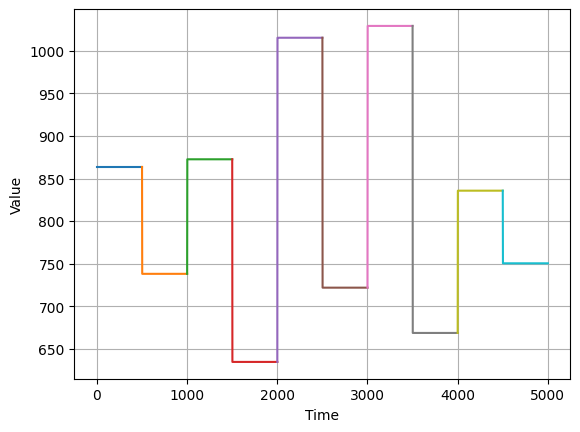

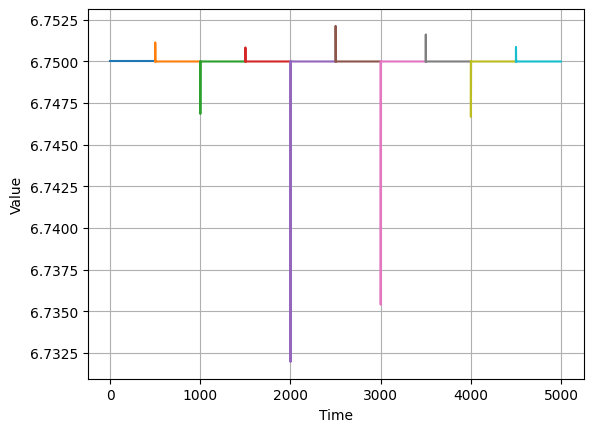

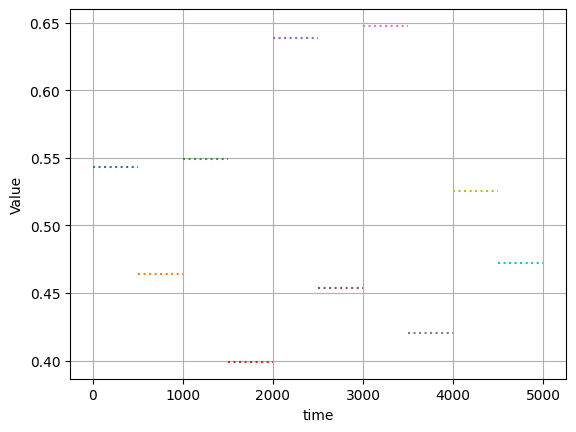

In [7]:
plt.figure("mass flow rate x time")
for i in range(0,nAlphas):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,nAlphas):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,nAlphas):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()

In [14]:
RNN_train = np.array(RNN_train)
RNN_trainFut = np.array(RNN_trainFut)
RNN_test = np.array(RNN_test)

X_train = []
y_train = []
x_test = []

# Nao estou gostando de ter que separar o RNN Train e RNN Test

for j in range(nAlphas_Met):
    for i in range(len(RNN_train[0][0])):
        X_train.append(RNN_train[j,:,i])
        x_test.append(RNN_test[j,:,i])
        if i == (len(RNN_train[0][0]) - 1):
            y_train.append(RNN_trainFut[j, :2, 0])
        else:
            y_train.append(RNN_train[j,:2,i+1])

newData = int((nData*nAlphas_Met)/timestep)

X_train = np.array(X_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

# Dividir os dados em treinamento e validação

X_train = tf.reshape(X_train, [newData,timestep,3])
y_train = tf.reshape(y_train, [newData,timestep,2])
x_test = tf.reshape(x_test, [newData,timestep,3])

num_samples = X_train.shape[0]
split_index = int(num_samples * 0.8)

# Dividir os dados
X_train_split = X_train[:split_index]
y_train_split = y_train[:split_index]
X_val = X_train[split_index:]
y_val = y_train[split_index:]



In [29]:
class DynamicNormalizeLayer(keras.Layer):
    def call(self, inputs):
        batch_min = tf.reduce_min(inputs, axis=[1, 2], keepdims=True)
        batch_max = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        return 2 * (inputs - batch_min) / (batch_max - batch_min) - 1, batch_min, batch_max

class DynamicDenormalizeLayer(keras.Layer):
    def call(self, inputs, batch_min, batch_max):
        return ((inputs + 1) / 2) * (batch_max - batch_min) + batch_min

class MyModel(tf.keras.Model):
    def __init__(self, num_layers, units2):
        super(MyModel, self).__init__()
        self.normalize_layer = DynamicNormalizeLayer()
        self.denormalize_layer = DynamicDenormalizeLayer()
        self.rnn_layers = []
        self.num_layers = num_layers
        self.units2 = units2
        self.inputs = None

    def build(self, input_shape):
        self.rnn_layers.append(keras.layers.Bidirectional(keras.layers.SimpleRNN(self.units2, return_sequences=True, activation='tanh')))
        for _ in range(self.num_layers):
            self.rnn_layers.append(keras.layers.SimpleRNN(self.units2, return_sequences=True, activation='tanh'))
        self.dense = keras.layers.Dense(2)

    def call(self, inputs):
        self.inputs = inputs
        normalized_inputs, batch_min, batch_max = self.normalize_layer(inputs)
        rnn_output = normalized_inputs
        for rnn_layer in self.rnn_layers:
            rnn_output = rnn_layer(rnn_output)
        dense_output = self.dense(rnn_output)
        return self.denormalize_layer(dense_output, batch_min, batch_max)

def lossCustom(y_true, y_pred):
    inputs = model.inputs
    derivada_vazao = (inputs[:, -2, 0] - 4*y_pred[:, -1, 0] + 3* y_pred[:, -2, 0])/2
    derivada_pressao = (inputs[:, -2, 1] - 4* y_pred[:, -1, 1] + 3*y_pred[:, -2, 1])/2
    phys_loss_vazao = tf.reduce_mean(tf.square(derivada_vazao - (A1/Lc)*((1.5 * P1) - y_pred[:, -2, 1]) * 1e6))
    phys_loss_pressao = tf.reduce_mean(tf.square(derivada_pressao - (C**2)/2 * (y_pred[:, -2, 0] - inputs[:, -1, -1]* kv * tf.sqrt((tf.abs(y_pred[:, -2, 1] * 1000 - P_out * 1000))))))
    data_loss = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0])) + tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))
    return data_loss + phys_loss_vazao + 1e-20* phys_loss_pressao

def create_model(lr, num_layers, units2):
    model = MyModel(num_layers, units2)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=lossCustom)
    return model    

early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  
    patience=30000,     
    restore_best_weights=True 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=100,          
    min_lr=1e-6          
)

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True) 
    units = trial.suggest_int('units', 32, 128)
    batch_size = trial.suggest_int('batch_size', 16, 128) 
    num_layers = trial.suggest_int('num_layers', 0, 5)      

    model = create_model(lr, num_layers, units)


    model.fit(X_train_split, y_train_split, epochs=2000, batch_size=batch_size, verbose=0)

    # Avaliação
    loss = model.evaluate(X_val, y_val, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # Ajuste o número de tentativas conforme necessário

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", study.best_params)

In [30]:
model = create_model(1e-6, 2, 32)


history = model.fit(X_train, y_train, epochs=20000, verbose=1, batch_size=64, callbacks= [early_stopping, reduce_lr])

Epoch 1/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 750888747008.0000 - learning_rate: 1.0000e-06
Epoch 2/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 739760209920.0000 - learning_rate: 1.0000e-06
Epoch 3/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 740865867776.0000 - learning_rate: 1.0000e-06
Epoch 4/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 733172006912.0000 - learning_rate: 1.0000e-06
Epoch 5/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 740746067968.0000 - learning_rate: 1.0000e-06
Epoch 6/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 732782395392.0000 - learning_rate: 1.0000e-06
Epoch 7/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 726695280640.0000 - learning_rate: 1.0000e-06
Epoch 8/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 724154384384.0000 - learning_rate: 1.0000e-06
Epoch 9/20000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 713205678080.0000 - learning_rate: 1.0000e-06
Epoch 10/20000
20/20 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

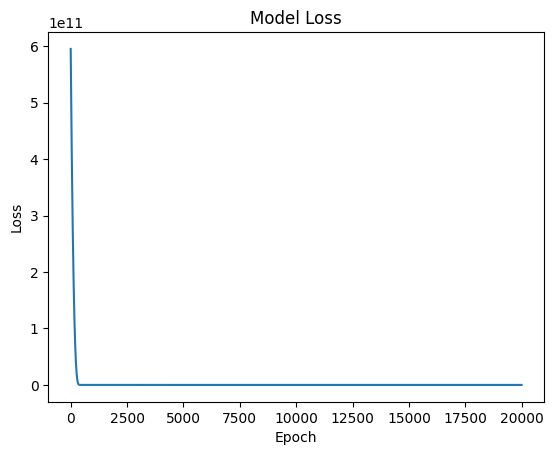

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
(1250, 2, 2)


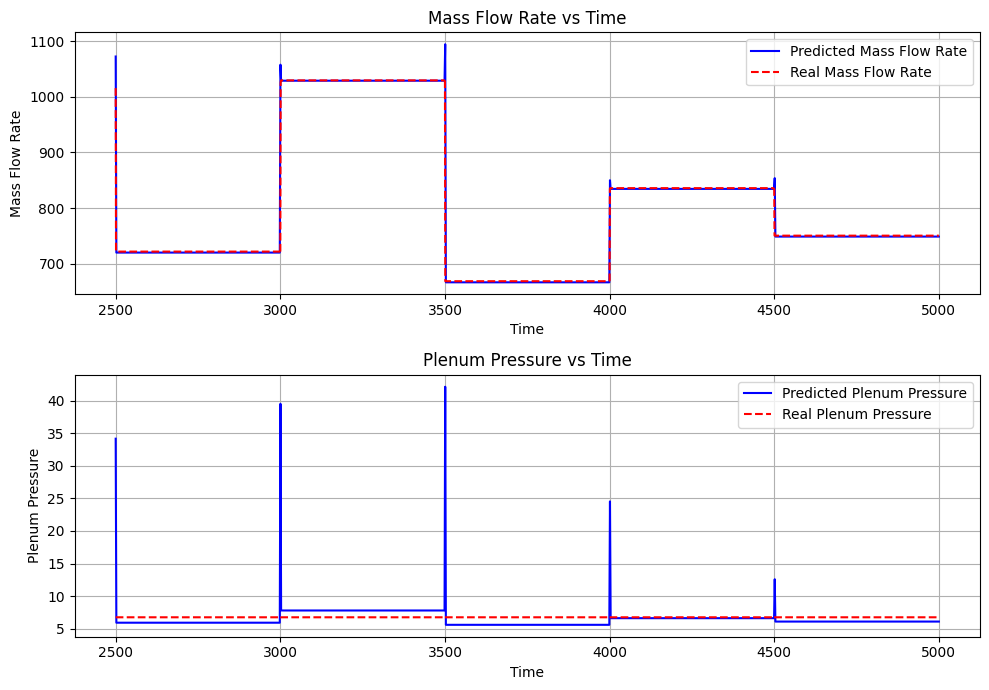

In [28]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

interval2 = [np.linspace(2500, 5000, 1250)]

# Assuming X_new is the new data for prediction
prediction = model.predict(x_test)
print(prediction.shape)

# Extraindo da Predicao
mass = prediction[:, -1, 0]
pressure = prediction[:, -1, 1]

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Gráfico da Mass Flow Rate vs. Tempo
axs[0].plot(interval2[0], np.squeeze(mass), label='Predicted Mass Flow Rate', color='blue')  # Gráfico da RNN em azul

for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--', label='Real Mass Flow Rate' if i == 5 else "")  # Gráfico real em vermelho

axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do Plenum vs. Tempo
axs[1].plot(interval2[0], np.squeeze(pressure), label='Predicted Plenum Pressure', color='blue')  # Gráfico da RNN em azul

for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--', label='Real Plenum Pressure' if i == 5 else "")  # Gráfico real em vermelho

axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

plt.tight_layout()  # Ajusta o layout para não sobrepor os elementos
plt.show()
